In [84]:
import gc
import math
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import rasterio.plot
import seaborn as sns
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import yaml
from ml_commons import *
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.models import (EfficientNet_V2_S_Weights, Swin_V2_S_Weights,
                                efficientnet_v2_s, swin_v2_s)

cudnn.benchmark = True
sns.set_theme()

In [85]:
modify_model_config = False

In [86]:
config = yaml.safe_load(open('ml_config.yml'))

In [87]:
prefix_dir = config['paths']['prefix_dir']
dataset_dir = os.path.join(prefix_dir, config['paths']['dataset_dir'])
output_dir = os.path.join(config['paths']['machine_learning_dir'], 'output')

In [88]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [89]:
'ML/output/efficientnet_v2_s_preset_3_weighted_sampler_ord_regr.pt'

'ML/output/efficientnet_v2_s_preset_3_weighted_sampler_ord_regr.pt'

In [90]:
state_filepath = os.path.join(config['paths']['machine_learning_dir'], 'output', 'efficientnet_v2_s_preset_3_16km_800_weighted_sampler_ord_regr.pt')
state = load_state(state_filepath)
config = state.config

In [91]:
config

{'paths': {'prefix_dir': '/p/project/haf/users/wessel2/aimlsse',
  'dataset_dir': 'dataset_16km_800',
  'machine_learning_dir': 'ML'},
 'model': {'name': 'EfficientNet',
  'freeze_parameters': False,
  'use_transfer_learning': True},
 'processing': {'batch_size': 6,
  'batch_normalization': False,
  'batch_accumulation': 8,
  'num_epochs': 32,
  'use_ordinal_regression': True,
  'use_one_neuron_regression': False,
  'ordinal_regression_loss': 'MSE',
  'activation_function': 'Sigmoid',
  'use_weighted_loss_function': False,
  'use_weighted_sampler': True,
  'use_manual_labels': False,
  'optimizer': 'Adam',
  'learning_rate_exp': 3,
  'momentum': 0.9,
  'use_dropout': False,
  'dropout_p': 0.5,
  'use_weight_decay': False,
  'weight_decay_exp': 3},
 'output': {'output_name': 'efficientnet_v2_s_preset_3_16km_800_weighted_sampler_ord_regr.pt',
  'show_samples': False,
  'show_summary': False}}

In [92]:
def if_not_present_set(category:str, variable:str, value):
    if category not in config:
        print(f'Config - add category: {category}')
        config[category] = {}
    if variable not in config[category]:
        print(f'Config - add variable: {variable} with value {value}')
        config[category][variable] = value

In [93]:
if_not_present_set('processing', 'optimizer',           'Adam'  )
if_not_present_set('processing', 'learning_rate_exp',   3       )
if_not_present_set('processing', 'momentum',            0.9     )
if_not_present_set('processing', 'use_dropout',         True    )
if_not_present_set('processing', 'dropout_p',           0.2     )
if_not_present_set('processing', 'use_weight_decay',    False   )
if_not_present_set('processing', 'weight_decay_exp',    4       )
if_not_present_set('processing', 'batch_normalization', False   )
if_not_present_set('processing', 'use_manual_labels', False   )

In [94]:
if modify_model_config:
    state.config = config
    save_state(state_filepath, state)

In [95]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [96]:
def print_model(model:nn.Module, name:str):
    spacing = '  '
    model_str = spacing + f'\n{spacing}'.join(str(model).splitlines())
    print(f'--- {name} ---\n{model_str}\n{"-" * (8 + len(name))}')

In [97]:
print(f'Using model: ' + config['model']['name'])
model_name = str(config['model']['name']).lower()
if model_name == 'swintransformer':
    model = swin_v2_s(weights=Swin_V2_S_Weights.DEFAULT)
elif model_name == 'efficientnet':
    model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
else:
    raise RuntimeError(f'Model "' + config['model']['name'] + '" is unknown')

if config['model']['freeze_parameters']:
    for param in model.parameters(): #freeze model
        param.requires_grad = False

print_model(get_model_head(model), 'Initial Model Head')
num_features = get_num_features(model)
print(f'Classification layer has {num_features} input features')
new_model_head = nn.Sequential()
# Before linear layer
if config['processing']['use_dropout']:
    new_model_head.append(nn.Dropout(p=config['processing']['dropout_p'], inplace=True))
# Linear layer
linear_layer = nn.Linear(num_features, 1 if config['processing']['use_one_neuron_regression'] else len(classes))
new_model_head.append(linear_layer)
# After linear layer
if (config['processing']['use_ordinal_regression'] or config['processing']['use_one_neuron_regression']) \
        and config['processing']['activation_function'] != False:
    activation_function = str(config['processing']['activation_function']).lower()
    if activation_function == 'sigmoid':
        activation_function = nn.Sigmoid()
    elif activation_function == 'relu':
        activation_function = nn.ReLU()
    elif activation_function == 'tanh':
        activation_function = nn.Tanh()
    else:
        raise RuntimeError(f'Unkown activation function: {activation_function}')
    new_model_head = new_model_head.append(activation_function)

set_model_head(model, new_model_head)
print_model(get_model_head(model), 'Modified Model Head')
# model = nn.DataParallel(model)
model = model.to(device)

Using model: EfficientNet
--- Initial Model Head ---
  Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
  )
--------------------------
Classification layer has 1280 input features
--- Modified Model Head ---
  Sequential(
    (0): Linear(in_features=1280, out_features=5, bias=True)
    (1): Sigmoid()
  )
---------------------------


In [98]:
model_trained = model
model_trained.load_state_dict(state.model_state)

<All keys matched successfully>

In [99]:
def prediction_to_label_ordinal_regression(pred: torch.Tensor) -> torch.Tensor:
    return (pred > 0.5).cumprod(axis=1).sum(axis=1) - 1

In [100]:
def prediction_to_label_one_neuron_regression(pred: torch.Tensor) -> torch.Tensor:
    return ((pred * max(classes)).round()).int().flatten()

In [101]:
if config['processing']['use_ordinal_regression']:
    outputs_to_predictions = prediction_to_label_ordinal_regression
elif config['processing']['use_one_neuron_regression']:
    outputs_to_predictions = prediction_to_label_one_neuron_regression
else:
    outputs_to_predictions = lambda outputs: torch.max(outputs, 1)[1]

In [102]:
def mean_std(loader:DataLoader):
  sum, squared_sum, num_batches = 0,0,0
  for data, _, _ in loader:
    sum += torch.mean(data,dim=[0,1,2])
    squared_sum += torch.mean(data**2,dim=[0,1,2])
    num_batches += 1
  mean = sum/num_batches
  std = (squared_sum/num_batches - mean**2)**0.5
  return mean, std

In [103]:
def batch_normalization(dataset:AimlsseImageDataset, dataset_type:DatasetType, dataset_transforms):
    mean, std = mean_std(dataset)
    print(f'{dataset_type.name} - mean {mean:.3f}, std {std:.3f}')
    if dataset_transforms is None:
        dataset_transforms = []
    return AimlsseImageDataset(dataset_type, dataset_dir,
                               transfrom = transforms.Compose(dataset_transforms + [transforms.Normalize(mean, std)]))

In [125]:
visualization_dataset = AimlsseImageDataset(DatasetType.TEST, dataset_dir, transfrom=None,
    use_manual_labels = True)
if config['processing']['batch_normalization']:
    visualization_dataset = batch_normalization(visualization_dataset, DatasetType.TEST, None)
visualization_dataloader = DataLoader(visualization_dataset,  batch_size=2, shuffle=True)

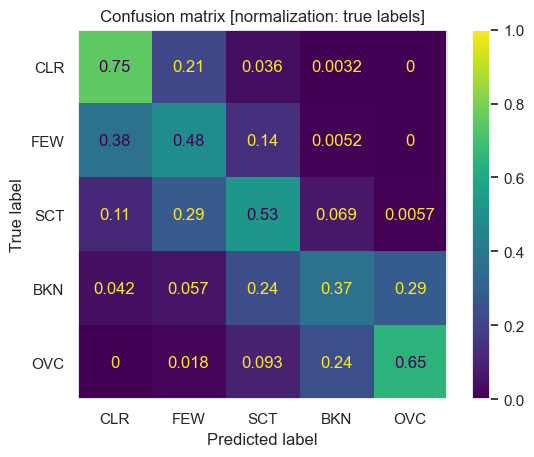

      true label  predicted label  index
0              1                1    710
1              4                4   1192
2              0                0    615
3              1                0   1023
4              1                0    451
...          ...              ...    ...
1281           4                4    503
1282           2                2    769
1283           0                0    300
1284           3                4    608
1285           0                0    494

[1286 rows x 3 columns]


In [126]:
cm_data = display_confusion_matrix(model_trained, device, visualization_dataloader, outputs_to_predictions,
                                   ConfusionMatrixNormalization.TRUE_LABELS)

In [127]:
cm_data

,true label,predicted label,index
0,FEW,FEW,710
1,OVC,OVC,1192
2,CLR,CLR,615
3,FEW,CLR,1023
4,FEW,CLR,451
...,...,...,...
1281,OVC,OVC,503
1282,SCT,SCT,769
1283,CLR,CLR,300
1284,BKN,OVC,608


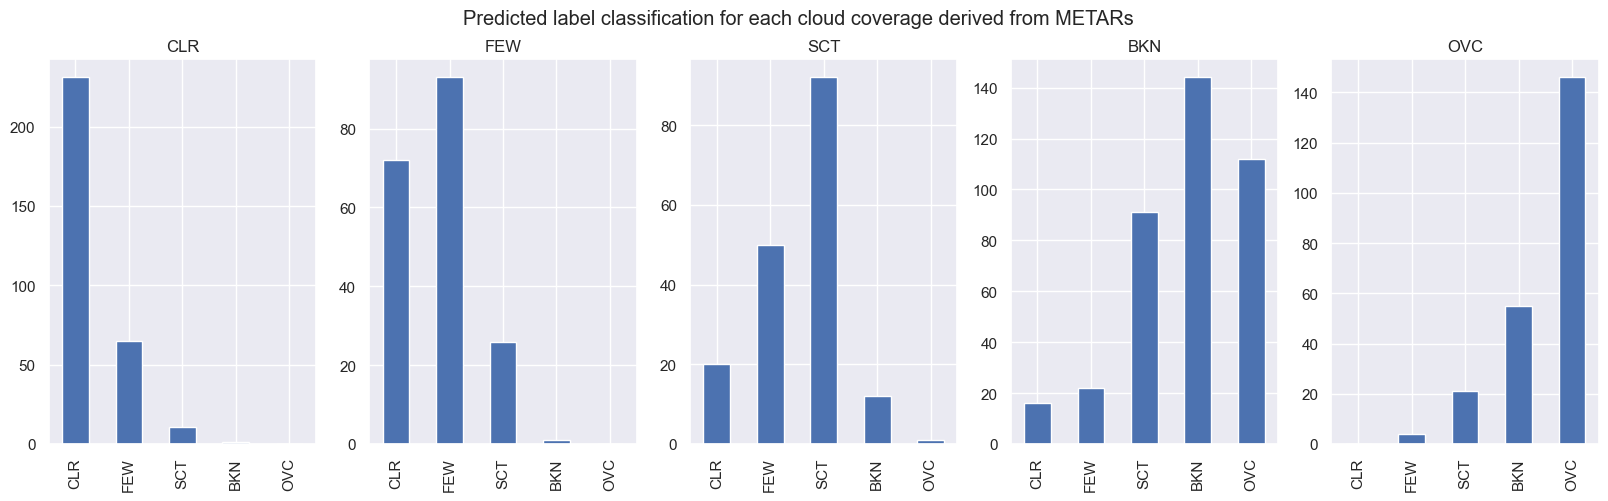

In [128]:
from collections import Counter

cc_counts = {}
fig, axs = plt.subplots(figsize=(4 * len(class_names), 5), ncols=len(class_names))
fig.suptitle('Predicted label classification for each cloud coverage derived from METARs')
for i, cc in enumerate(class_names):
    ax: plt.Axes = axs[i]
    counted_labels = pd.Series(Counter(cm_data[cm_data['true label'] == cc]['predicted label']))
    for cc_ in class_names:
        if cc_ not in counted_labels:
            counted_labels[cc_] = 0
    counted_labels = counted_labels.loc[class_names]
    counted_labels.plot.bar(ax=ax, title=cc)
    cc_counts[cc] = counted_labels

In [129]:
# rows   = label given by METAR
# colums = predicted label
cc_dist = pd.DataFrame(cc_counts).T
cc_dist

,CLR,FEW,SCT,BKN,OVC
CLR,231,65,11,1,0
FEW,72,93,26,1,0
SCT,20,50,92,12,1
BKN,16,22,91,144,112
OVC,0,4,21,55,146


In [130]:
cc_dist_rel = (cc_dist.T / cc_dist.sum(axis=1)).T
assert(all([math.isclose(x, 1.0) for x in cc_dist_rel.sum(axis=1)]))
cc_dist_rel

,CLR,FEW,SCT,BKN,OVC
CLR,0.750000,0.211039,0.035714,0.003247,0.000000
FEW,0.375000,0.484375,0.135417,0.005208,0.000000
SCT,0.114286,0.285714,0.525714,0.068571,0.005714
BKN,0.041558,0.057143,0.236364,0.374026,0.290909
OVC,0.000000,0.017699,0.092920,0.243363,0.646018


In [131]:
def direct_neighbor_accumulation(data_collection:List[pd.DataFrame], labels:List[str]) -> pd.DataFrame:
    result = []
    for i, cc in enumerate(class_names):
        local_result = {'cloud cover': cc}
        for k, data in enumerate(data_collection):
            cc_sum = data.loc[cc, cc]
            if i > 0:
                cc_sum += data.loc[cc, class_names[i - 1]]
            if i < len(class_names) - 1:
                cc_sum += data.loc[cc, class_names[i + 1]]
            local_result[labels[k]] = cc_sum
        result += [local_result]
    result = pd.DataFrame(result)
    result.set_index('cloud cover', inplace=True)
    return result

cc_neighbor_acc = direct_neighbor_accumulation([cc_dist_rel], ['f1_score'])
cc_neighbor_acc

,f1_score
cloud cover,
CLR,0.961039
FEW,0.994792
SCT,0.880000
BKN,0.901299
OVC,0.889381


[Text(0, 0, '0.961'),
 Text(0, 0, '0.995'),
 Text(0, 0, '0.880'),
 Text(0, 0, '0.901'),
 Text(0, 0, '0.889')]

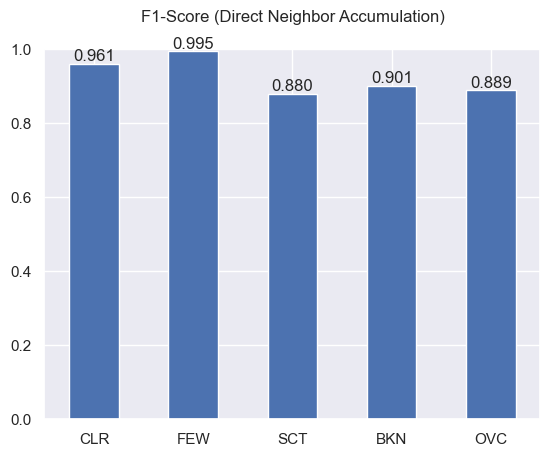

In [132]:
ax = cc_neighbor_acc.plot.bar(legend=False, rot=0)
ax.set_ylim(0, 1)
ax.set_xlabel(None)
ax.set_title('F1-Score (Direct Neighbor Accumulation)', pad=20)
ax.bar_label(ax.containers[0], fmt='%.3f')

In [133]:
false_predictions = cm_data[cm_data['true label'] != cm_data['predicted label']].copy()
print(f'{false_predictions.shape[0]} of {cm_data.shape[0]} images were not identified correctly'
      f' [{false_predictions.shape[0] / cm_data.shape[0] * 100.0:.2f} %]')

580 of 1286 images were not identified correctly [45.10 %]


In [134]:
false_predictions_grouped = [false_predictions[false_predictions['true label'] == cc] for cc in class_names]
all_predictions_grouped = [cm_data[cm_data['true label'] == cc] for cc in class_names]
for i, cc in enumerate(class_names):
    print(f'{false_predictions_grouped[i].shape[0]} of {all_predictions_grouped[i].shape[0]} {cc} images were not identified correctly'
        f' [{false_predictions_grouped[i].shape[0] / all_predictions_grouped[i].shape[0] * 100.0:.2f} %]')

77 of 308 CLR images were not identified correctly [25.00 %]
99 of 192 FEW images were not identified correctly [51.56 %]
83 of 175 SCT images were not identified correctly [47.43 %]
241 of 385 BKN images were not identified correctly [62.60 %]
80 of 226 OVC images were not identified correctly [35.40 %]


In [135]:
false_predictions['image path'] = false_predictions['index'].apply(lambda x: visualization_dataset.get_image_path(x))
false_predictions['timedelta [minutes]'] = false_predictions['index'].apply(lambda x: visualization_dataset.get_timedelta_minutes(x))
false_predictions

,true label,predicted label,index,image path,timedelta [minutes]
3,FEW,CLR,1023,data\dataset_16km_800\test\CDS\7c97ca4e-c9ee-4581-99f6-44a35527ca4f.tif,-25.983733
4,FEW,CLR,451,data\dataset_16km_800\test\OMK\32b0b7b3-1ae3-40b2-80a7-bd14752fa829.tif,-7.150400
5,BKN,OVC,1145,data\dataset_16km_800\test\COM\b77c0b0b-7394-4e40-8630-759d491d7d53.tif,6.182933
7,BKN,SCT,278,data\dataset_16km_800\test\NSI\d79f94f0-32a4-47f5-b069-11f2c8810b7a.tif,23.682933
8,SCT,FEW,145,data\dataset_16km_800\test\L08\6b597899-e359-4956-bec7-7272e45e5c0d.tif,-8.650417
...,...,...,...,...,...
1274,CLR,FEW,409,data\dataset_16km_800\test\HRF\d6445a73-eadf-4b25-8d4d-ac0c8a34dd16.tif,-0.017067
1276,BKN,SCT,324,data\dataset_16km_800\test\HLN\09a07cb0-538e-442f-b4dc-8dec67bea65b.tif,-26.317067
1278,BKN,OVC,217,data\dataset_16km_800\test\MMH\a75d3d56-8d3e-4617-abe6-29b70e142a77.tif,-5.650400
1279,FEW,CLR,1088,data\dataset_16km_800\test\BGD\9adc99ed-1ba8-4e0f-b1d4-b7809836287d.tif,22.016267


In [136]:
false_predictions_idx = 0

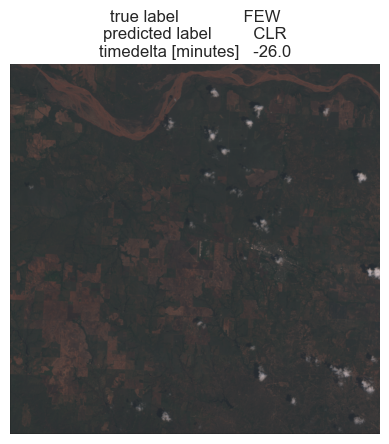

In [137]:
if false_predictions_idx < len(visualization_dataset):
    row = false_predictions.iloc[false_predictions_idx]
    image = rasterio.open(row['image path'])
    image_tensor = torch.from_numpy(image.read())
    image.close()

    plt.title(row[['true label', 'predicted label', 'timedelta [minutes]']].to_string(float_format=(lambda x: f'{x:.1f}')))
    plt.axis('off')
    plt.imshow(image_tensor.permute(1, 2, 0))
    false_predictions_idx += 1

In [138]:
pd.set_option('display.max_colwidth', None)

In [139]:
scoreboard = pd.DataFrame(state.scoreboard)
scoreboard['accuracy'] = scoreboard['accuracy'].apply(lambda t: t.item())
scoreboard.head()

,epoch,phase,loss,accuracy,precision,recall,f1_score,time,precision CLR,recall CLR,...,f1_score FEW,precision SCT,recall SCT,f1_score SCT,precision BKN,recall BKN,f1_score BKN,precision OVC,recall OVC,f1_score OVC
0,0,Training,0.095275,0.340004,0.417864,0.340004,0.364343,925.951394,0.536638,0.248627,...,0.325105,0.294404,0.358519,0.323313,0.317528,0.285988,0.300934,0.632844,0.452722,0.527840
1,0,Validation,0.069831,0.531915,0.724305,0.531915,0.589474,97.370038,0.969101,0.540752,...,0.156463,0.182186,0.483871,0.264706,0.307692,0.303797,0.305732,0.745645,0.701639,0.722973
2,1,Training,0.076926,0.411222,0.454276,0.411222,0.423871,866.901351,0.583402,0.350964,...,0.354176,0.336641,0.449902,0.385117,0.339959,0.343107,0.341526,0.664890,0.537321,0.594337
3,1,Validation,0.066380,0.519307,0.737150,0.519307,0.573515,81.192642,0.986971,0.474922,...,0.162162,0.211618,0.548387,0.305389,0.339869,0.329114,0.334405,0.736156,0.740984,0.738562
4,2,Training,0.074735,0.400235,0.446524,0.400235,0.411558,790.423080,0.592825,0.327552,...,0.361697,0.317031,0.426903,0.363854,0.336102,0.337420,0.336760,0.673606,0.516212,0.584499


In [140]:
print(f'Total time: {scoreboard.time.sum() / 60:.1f} [minutes]')

Total time: 464.3 [minutes]


In [141]:
scoreboard_training = scoreboard[scoreboard['phase'] == 'Training']
scoreboard_validation = scoreboard[scoreboard['phase'] == 'Validation']

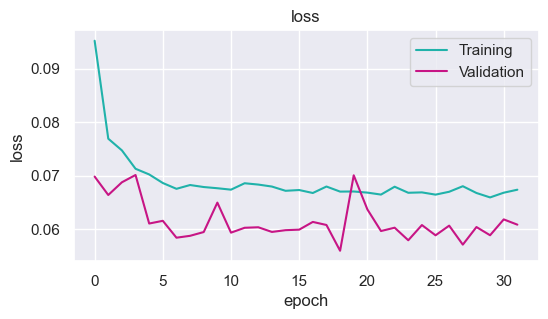

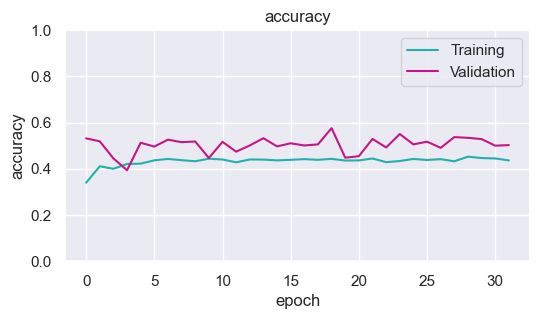

In [142]:
def plot_scoreboard(x_label:str, y_labels:List[str], figsize:Tuple[float, float]):
    def plot_single(ax:plt.Axes, data:pd.DataFrame, y_label:str, phase:str, colors):
        ax.plot(x_label, y_label, data=data, label=phase, color=colors[phase])
        ax.legend(loc='best')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_title(y_label)
        if y_label.startswith('f1_score') or y_label.startswith('precision') or y_label.startswith('recall') or y_label.startswith('accuracy'):
            ax.set_ylim(0, 1)

    assert x_label in scoreboard, f'Label {x_label} is not in scoreboard'
    for y_label in y_labels:
        assert y_label in scoreboard, f'Label {y_label} is not in scoreboard'
    colors = {
        'Training': 'lightseagreen',
        'Validation': 'mediumvioletred'
    }
    fig, axs = plt.subplots(figsize=(figsize[0] * len(y_labels), figsize[1]), ncols=len(y_labels))
    for phase in ['Training', 'Validation']:
        data = scoreboard[scoreboard['phase'] == phase]
        if isinstance(axs, plt.Axes):
            plot_single(axs, data, y_labels[0], phase, colors)
        else:
            for i, y_label in enumerate(y_labels):
                plot_single(axs[i], data, y_label, phase, colors)
                

plot_scoreboard('epoch', ['loss'], figsize=(6, 3))
plot_scoreboard('epoch', ['accuracy'], figsize=(6, 3))

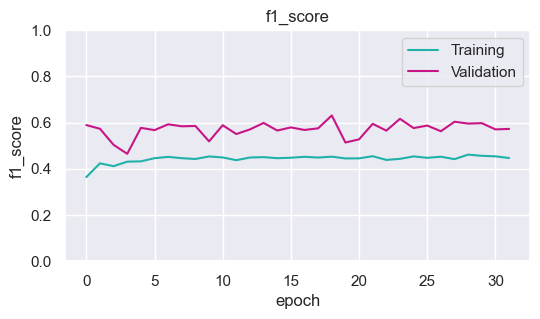

In [143]:
plot_scoreboard('epoch', ['f1_score'], figsize=(6, 3))

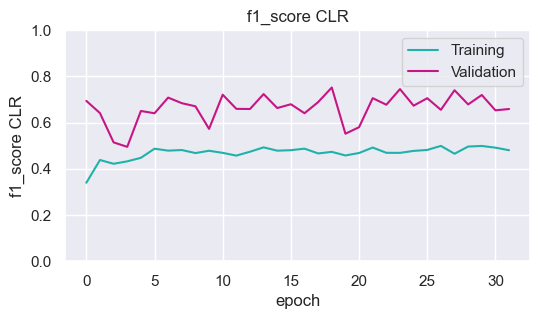

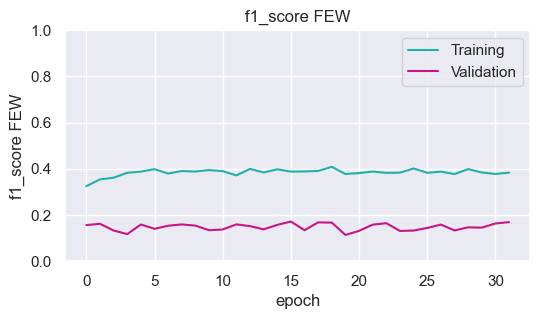

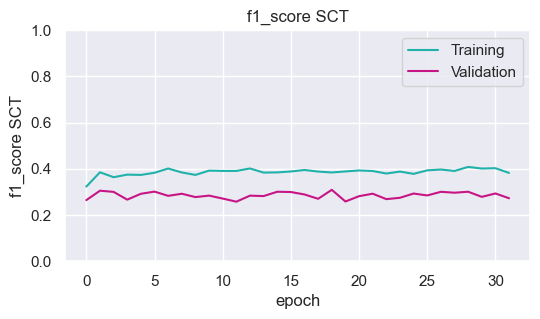

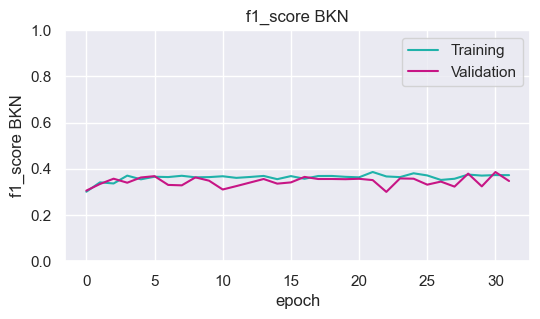

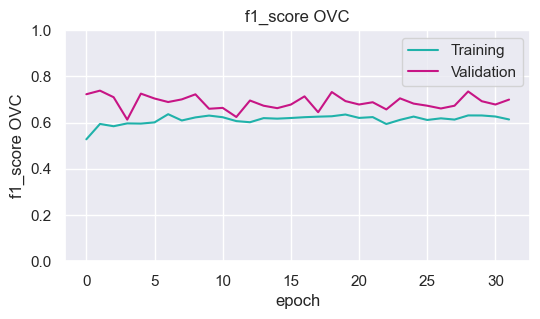

In [144]:
for cc in class_names:
    plot_scoreboard('epoch', [f'f1_score {cc}'], figsize=(6, 3))

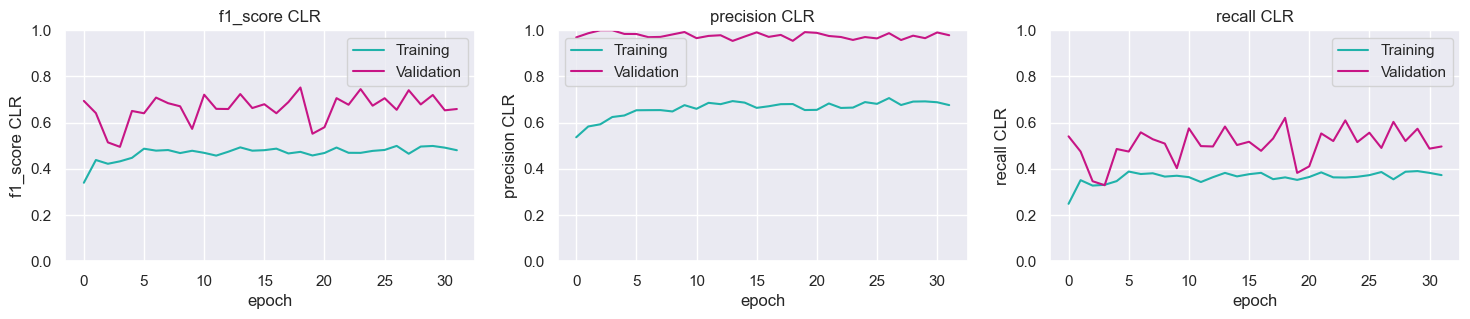

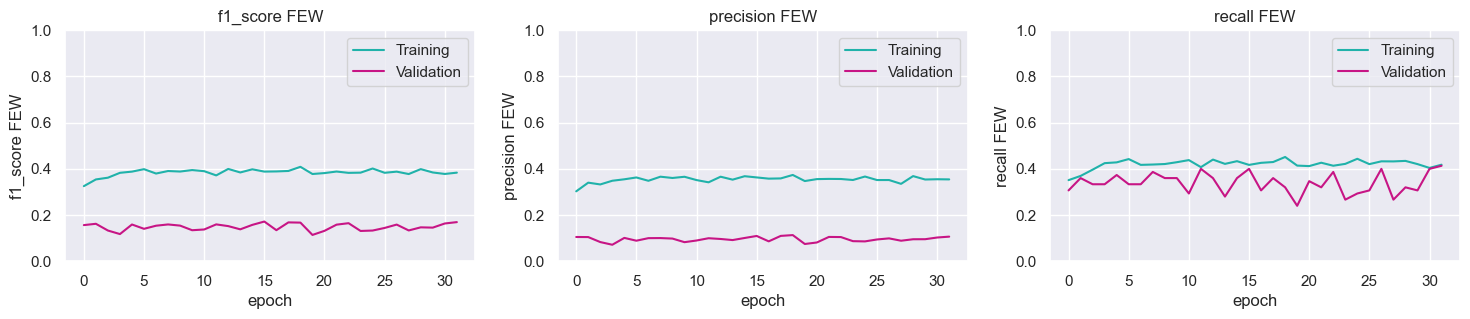

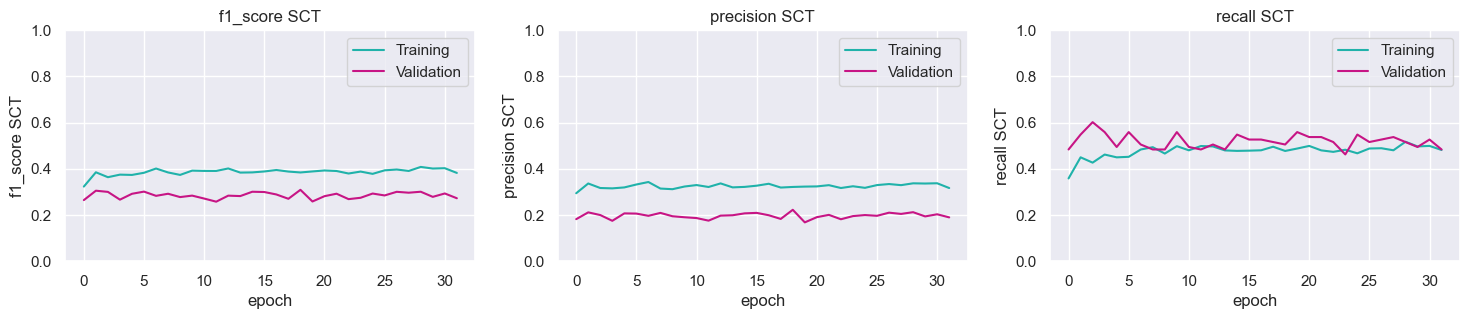

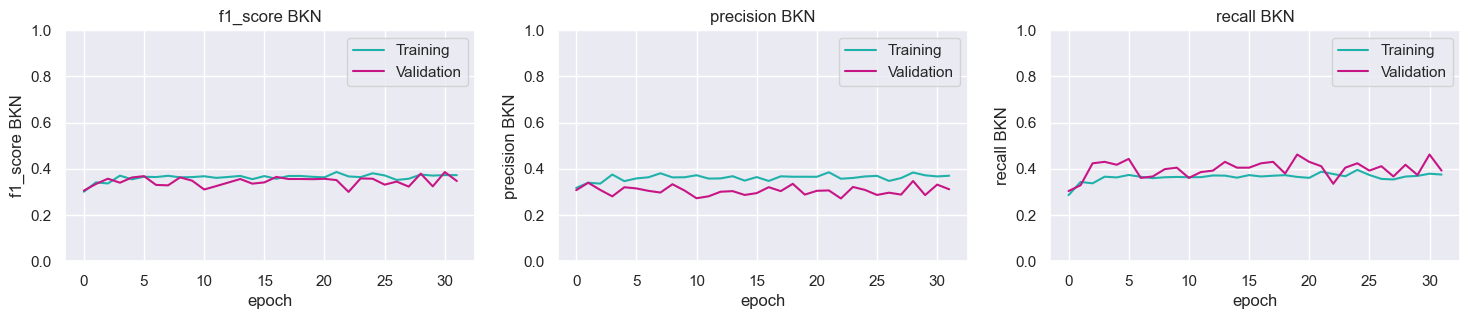

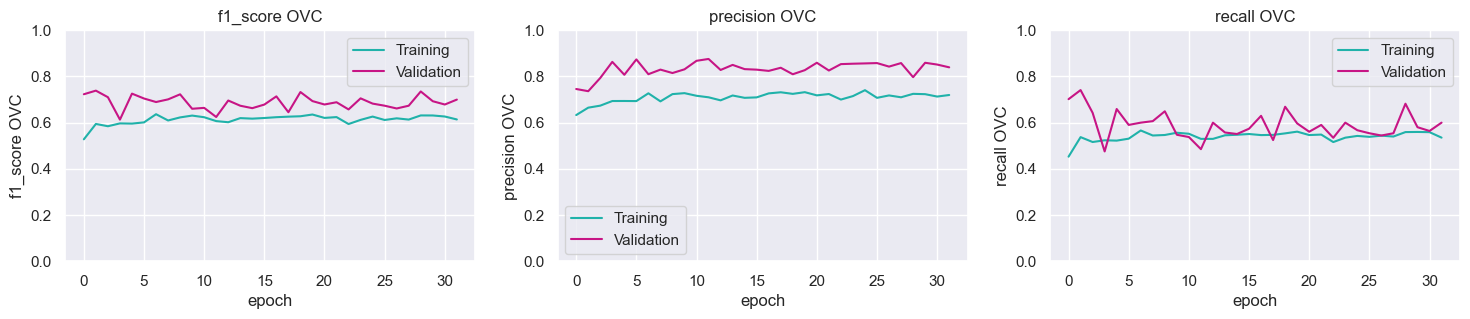

In [145]:
for cc in class_names:
    plot_scoreboard('epoch', [f'f1_score {cc}', f'precision {cc}', f'recall {cc}'], figsize=(6, 3))